#### Problem:  Generating Hand Written Digits

#### Technique: Generative Adversarial Network (GAN)

Language: Python

Library: PyTorch

This is a Vanilla GAN, which is the first ever GAN model proposed by Ian J. Goodfellow! 

Paper by Ian J. Goodfellow et al.: https://arxiv.org/abs/1406.2661

Source: https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

### GAN Summary
##### Generative Adversarial Networks are composed of two models:

The first model is called a Generator and it aims to generate new data similar to the expected one. The Generator could be asimilated to a human art forger, which creates fake works of art.
    
The second model is named the Discriminator. This model’s goal is to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ — generated by a forger. In this scenario, a Discriminator is analogous to an art expert, which tries to detect artworks as truthful or fraud.

##### How do these models interact? 
Paraphrasing the original paper which proposed this framework, it can be thought of the Generator as having an adversary, the Discriminator. The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

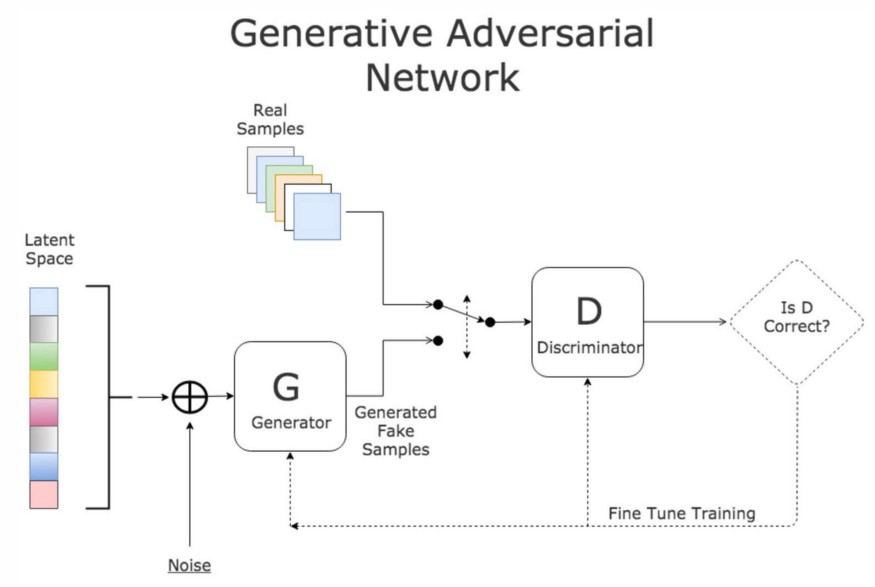

### Mathematical Summary of GAN

A neural network $G(z, \theta_1)$ is used to model the Generator mentioned above. It’s role is mapping input noise variables $z$ to the desired data space $x$ (say images).

Another neural network $D(x, \theta_2)$ models the discriminator and outputs the probability that the data came from the real dataset, in the range $(0,1)$.

In both cases, $\theta_i$ represents the weights or parameters that define each neural network.

As a result, the Discriminator is trained to correctly classify the input data as either real or fake. This means it's weights are updated as to maximize the probability that any real data input $x$ is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset. In more technical terms, the loss/error function used maximizes the function $D(x)$, and it also minimizes $D(G(z))$.

Furthermore, the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator's weight's are optimized to maximize the probability that any fake image is classified as belonging to the real dataset. Formally this means that the loss/error function used for this network maximizes $D(G(z))$.

In practice, the logarithm of the probability (e.g. $log\; D(\dots)$) is used in the loss functions instead of the raw probabilies, since using a $log$ loss heavily penalises classifiers that are confident about an incorrect classification.

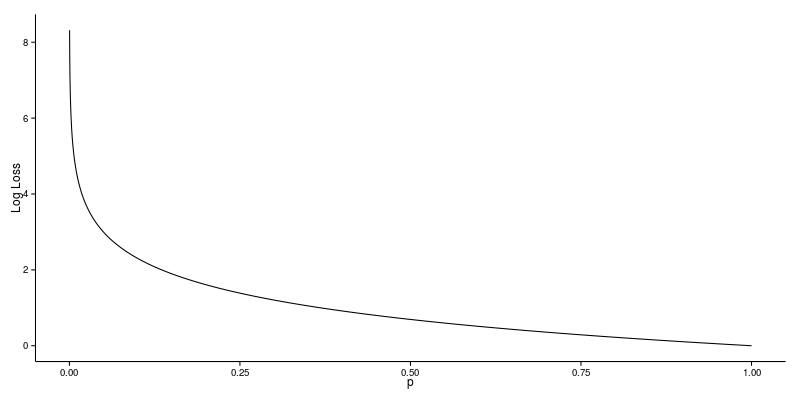


After several steps of training, if the Generator and Discriminator have enough capacity (if the networks can approximate the objective functions), they will reach a point at which both cannot improve anymore. At this point, the generator generates realistic synthetic data, and the discriminator is unable to differentiate between the two types of input.

Since during training both the Discriminator and Generator are trying to optimize opposite loss functions, they can be thought of two agents playing a minimax game with value function $V(G,D)$. In this minimax game, the generator is trying to maximize it's probability of having it's outputs recognized as real, while the discriminator is trying to minimize this same value.

$\min_G \max_D V(D,G)$ = $E_{x\sim p_{data}(x)}[log D(x)]$ $+$ $E_{z\sim p_z(z)}[log(1-D(G(z)))]$

To train the GAN here, we will be using stochastic gradient descent, as it has proven to be succesfull in multiple fields.

##### The fundamental steps to train a GAN can be described as following:
   1. Sample a noise set and a real-data set, each with size m.
   2. Train the Discriminator on this data.
   3. Sample a different noise subset with size m.
   4. Train the Generator on this data.
   5. Repeat from Step 1.
   
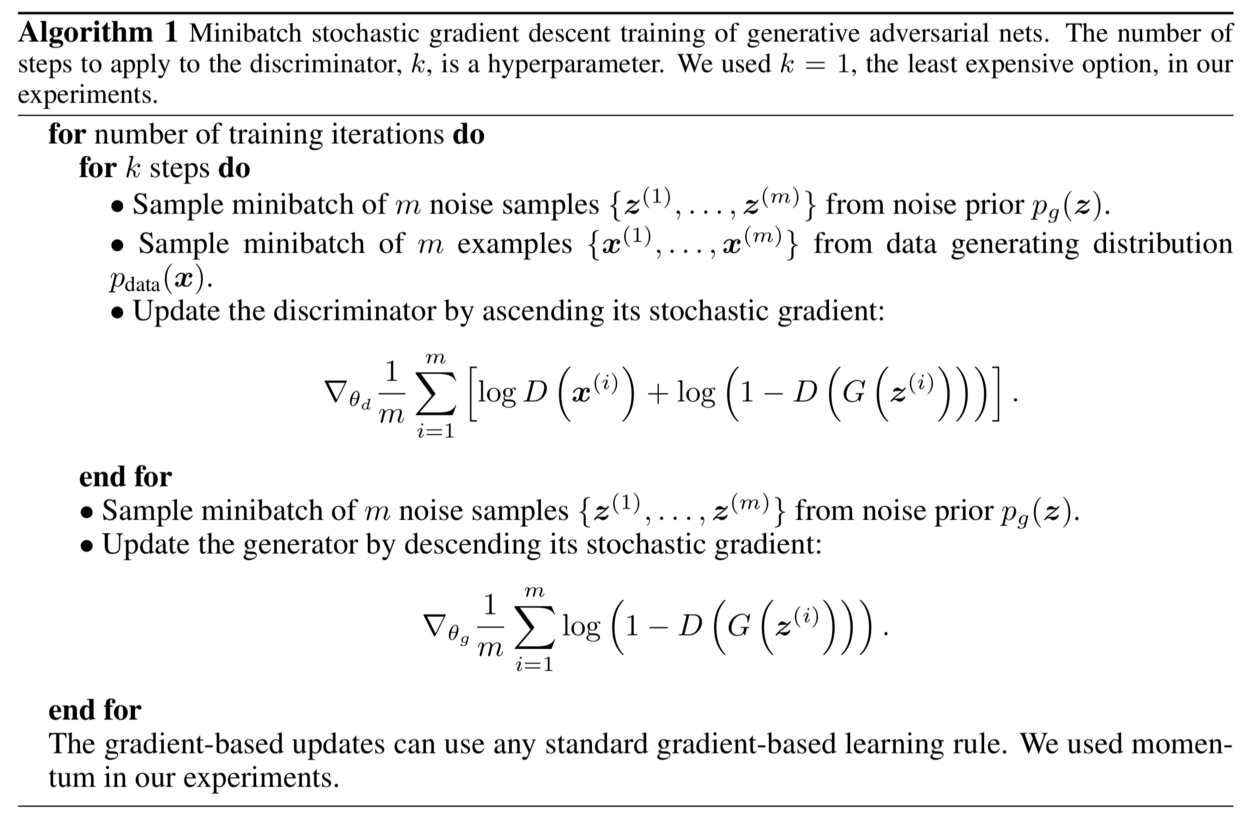

# Code the GAN
### Install the requirements

In [1]:
#! pip install torchvision tensorboardx jupyter matplotlib numpy

### Import Libraries and Initialise Variables

In [2]:
%load_ext autoreload
%matplotlib inline

In [3]:
%autoreload 2

from IPython import display

#from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [4]:
DATA_FOLDER = 'MNIST'

##### To log our progress, we will import an additional file called myutils.py

You need to download the file and put it in the same folder where your GAN file will be. It is not necessary that you understand the code in this file, as it is only used for visualization purposes.

In [5]:
from myutils import Logger

### Dataset

The dataset we’ll be using here is LeCunn’s MNIST dataset, consisting of about 60.000 black and white images of handwritten digits, each with size 28x28 pixels². This dataset will be preprocessed according to some useful ‘hacks’ proven to be useful for training GANs.

**Specifically, the input values which range in between [0, 255] will be normalized between -1 and 1. This means the value 0 will be mapped to -1, the value 255 to 1, and similarly all values in between will get a value in the range [-1, 1].

### Load Data

In [6]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [7]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

### Networks
#### Discriminator

Next, we’ll define the neural networks, starting with the Discriminator. This network will take a flattened image as its input, and return the probability of it belonging to the real dataset, or the synthetic dataset. The input size for each image will be 28x28=784. Regarding the structure of this network, it will have three hidden layers, each followed by a Leaky-ReLU nonlinearity and a Dropout layer to prevent overfitting. A Sigmoid/Logistic function is applied to the real-valued output to obtain a value in the open-range (0, 1).

In [8]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
discriminator = DiscriminatorNet()
if torch.cuda.is_available():
    discriminator.cuda()

We also need some additional functionality that allows us to convert a flattened image into its 2-dimensional representation, and another one that does the opposite.

In [9]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

#### Generator

On the other hand, the Generative Network takes a latent variable vector as input, and returns a 784 valued vector, which corresponds to a flattened 28x28 image. Remember that the purpose of this network is to learn how to create undistinguishable images of hand-written digits, which is why its output is itself a new image.

This network will have three hidden layers, each followed by a Leaky-ReLU nonlinearity. The output layer will have a TanH activation function, which maps the resulting values into the (-1, 1) range, which is the same range in which our preprocessed MNIST images is bounded.

In [10]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet()
if torch.cuda.is_available():
    generator.cuda()

We also need some additional functionality that allows us to create the random noise. The random noise will be sampled from a normal distribution with mean 0 and variance 1 as proposed in this link.

In [11]:
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [12]:
# discriminator = DiscriminatorNet()
# generator = GeneratorNet()
# if torch.cuda.is_available():
#     discriminator.cuda()
#     generator.cuda()

### Optimization

Here we'll use Adam as the optimization algorithm for both neural networks, with a learning rate of 0.0002. The proposed learning rate was obtained after testing with several values, though it isn’t necessarily the optimal value for this task.

In [13]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

The loss function we’ll be using for this task is named Binary Cross Entopy Loss (BCE Loss), and it will be used for this scenario as it resembles the log-loss for both the Generator and Discriminator defined earlier in the post (see Modeling Mathematically a GAN). Specifically we’ll be taking the average of the loss calculated for each minibatch. Following is our loss function.

$L = \{l_1, \dots, l_N\}^T, l_i = -w_i[y_i.log(v_i) + (1-y).log(1-v_i)]$

In this formula the values $y$ are named targets, $v$ are the inputs, and $w$ are the weights. Since we don't need the weight at all, it'll be set to $w_i = 1$ for all $i$.

##### Discriminator Loss

$\frac{1}{m}\sum_{i=1}^m[log D (x^{(i)}) + log(1 - D (G(z^{(i)})))] $

If we replace $v_i = D(x_i)$ and $y_i = 1 \forall i$ (for all $i$) in the BCE-Loss definition, we obtain the loss related to the real-images. Conversely if we set $v_i$ = D(G(z_i)) and $y_i = 0 \forall i$, we obtain the loss related to the fake-images. In the mathematical model of a GAN, as described earlier, the gradient of this had to be ascended, but PyTorch and most other Machine Learning frameworks usually minimize functions instead. Since maximizing a function is equivalent to minimizing it's negative, and the BCE-Loss term has a minus sign, we don't need to worry about the sign.

In [14]:
# Loss function
loss = nn.BCELoss()

Additionally, we can observe that the real-images targets are always ones, while the fake-images targets are zero, so it would be helpful to define the following functions.

In [15]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

##### Generator Loss

$\frac{1}{m}\sum_{i=1}^m log (1 - D(G(z^{(i)})))$

Rather than minimizing $log(1- D(G(z)))$, training the Generator to maximize $log D(G(z))$ will provide much stronger gradients early in training. Both losses may be swapped interchangeably since they result in the same dynamics for the Generator and Discriminator.

Maximizing $log D(G(z))$ is equivalent to minimizing it's negative and since the BCE-Loss definition has a minus sign, we don't need to take care of the sign. Similarly to the Discriminator, if we set $v_i = D(G(z_i))$ and $y_i = 1 \forall i$, we obtain the desired loss to be minimized.

### Define Training Helpers

#### Discriminator Training Helper

In [16]:
'''
By summing up the two discriminator losses we obtain the total mini-batch loss for 
the Discriminator. In practice, we will calculate the gradients separately, 
and then update them together.
'''
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

#### Generator Training Helper

In [17]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Testing 

Last thing before we run our algorithm, we want to visualize how the training process develops while our GAN learns. To do so, we will create a static batch of noise, every few steps we will visualize the batch of images the generator outputs when using this noise as input.

In [18]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

Now that we've defined the dataset, networks, optimization and learning algorithms we can train our GAN. This part is really simple, since the only thing we've got to do is to code in python the pseudocode shown earlier on traning a GAN (see Training a GAN).

We'll be using all the pieces we've coded already, plus the logging file I asked you to download earlier for this procedure:

In [19]:
# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200
# custom Logger (not the one from standard python)
logger = Logger(model_name='VGAN', data_name='MNIST')

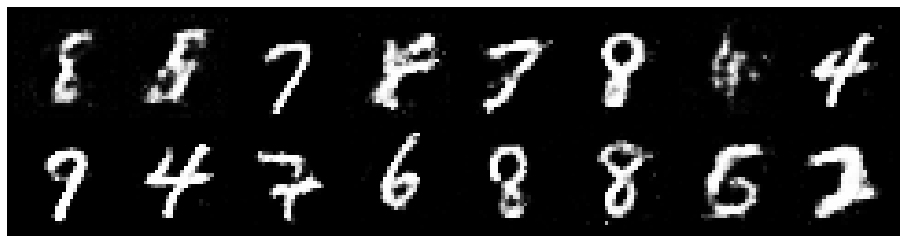

Epoch: [162/200], Batch Num: [100/600]
Discriminator Loss: 1.3948, Generator Loss: 0.7216
D(x): 0.5434, D(G(z)): 0.5012


In [ ]:
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

### Additional Investigation

In [ ]:
test_images = vectors_to_images(generator(test_noise)).data.cpu()

In [ ]:
type(test_images[0])

In [ ]:
test_images[0][0].shape

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
tensor_image = test_images[1][0]
#tensor_image = tensor_image.permute(1, 2, 0)
axs = plt.imshow(tensor_image.detach().cpu().numpy())